# Reliability Analysis (AK-MCS)

## Intoduction

This example file demonstrates how to generate samples using AKMCS object for reliability analysis. AKMCS requires Krig object and RunModel object, which enables UQpy to execute models in third-party software. The files necessary to run this example are:

1. The input template - 'abaqus_input.py'
2. The model script - 'abaqus_fire_analysis.py'
3. The output script - 'extract_abaqus_output.py'
4. The script used by the output script - 'abaqus_output_script.py'

Note: To execute the example in this notebook, it is necessary to have access to the finite element solver Abaqus.

## Description of the model

This example builds and analyzes a finite element model of a beam bearing uniformly distributed load, which is then subjected to fire load.

## The Script: 

Import the python modules used in this example, note down the start time and the current directory, which will be used later to save the results.

In [1]:
from UQpy.RunModel import *
from UQpy.SampleMethods import STS, AKMCS
from UQpy.Surrogates import Kriging
from UQpy.Distributions import Uniform, Normal
import time
import os
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.colors import ListedColormap

t = time.time()

## Building the model: 

There are two probabilistic input variables, the fire load density and the yield strength. The fire load density is denoted as 'qtd' and the yield strength is denoted as 'fy' in the template input script. These are different from the default variable names used by RunModel, and hence they must be passed in as one of the inputs while building the RunModel object.

In [2]:
var_names = ['qtd', 'fy']

### Create the model object: 

In [3]:
abaqus_sfe_model = RunModel(model_script='abaqus_fire_analysis.py', input_template='abaqus_input.py',
                            output_script='extract_abaqus_output.py', vec=False,
                            var_names=var_names, ntasks=1, model_dir='SFE_Example', verbose=False)
print('Example: Created the model object.')

Example: Created the model object.


### Generate samples from UQpy STS class: 

The fire load density is assumed to be uniformly distributed between 50 MJ/m^2 and 450 MJ/m^2. The yield strength is assumed to be normally distributed, with the parameters being: mean = 250 MPa and coefficient of variation of 7%.

In [4]:
marginals = [Uniform(loc=50, scale=400), Normal(loc=250e6, scale=0.07*250e6)]

print('Example: Created the distribution object')

Example: Created the distribution object


In [5]:
x_sts = STS(dist_object=marginals, sts_design=[5, 5], random_state=1)

print('Example: Created the STS samples')

Example: Created the STS samples


### Instantiate a UQpy Krig object: 

A Krig object is initiated with Linear regression model and Exponential correlation model. 

In [6]:
metamodel = Kriging(reg_model='Linear', corr_model='Exponential', n_opt=10, corr_model_params=np.ones(2), random_state=2)

print('Example: Created the Krig object.')

Example: Created the Krig object.


### Instantiate a UQpy AKMCS object: 

AKMCS class object is initiated using STS samples and RunModel, Krig objects. 100,000 MCS samples are generated and one sample is selected after each iteration using 'U'-function as learning criteria.

In [7]:
akmcs = AKMCS(runmodel_object=abaqus_sfe_model, samples=x_sts.samples, krig_object=metamodel, nlearn=10**5, 
              learning_function='U', dist_object=marginals, random_state=3)

AKMCS object is executed to generate 75 more samples using 'U'-function, such that number of total samples is 100.

In [8]:
akmcs.run(nsamples=100)

### Plot the results: 

Results are loaded from the pickle dump. Krig method is used to evaluate structural fire model at the defined meshgrid.

In [9]:
qois = akmcs.runmodel_object.qoi_list

# Plot label font size
fs = 18
# Size of dots and cross in scatter plot
ss = 150

num, cov_yield = 250, 0.07
x1 = np.linspace(50, 450, num)
x2 = np.linspace((1-3*cov_yield)*250e6, (1+3*cov_yield)*250e6, num)
x1g, x2g = np.meshgrid(x1, x2)
x1gv, x2gv = x1g.reshape(x1g.size, 1), x2g.reshape(x2g.size, 1)

y2 = akmcs.krig_object.predict(np.concatenate([x1gv, x2gv], 1)).reshape(x1g.shape[0], x1g.shape[1])

nd = np.prod(x_sts.sts_design)
S_initial0 = np.atleast_2d(akmcs.samples[:nd, 0]).T
S_initial1 = np.atleast_2d(akmcs.samples[:nd, 1]).T/1e6
Y_initial = np.atleast_2d(qois).T[:nd, :]

S_final0 = np.atleast_2d(akmcs.samples[nd:, 0]).T
S_final1 = np.atleast_2d(akmcs.samples[nd:, 1]).T/1e6
Y_final = np.atleast_2d(qois).T[nd:, :]

This plot shows the failure region and safe region in green and red color, respectively. Also, green dots/cross are the new samples generated using AKMSC class and black dots/cross are samples generated using STS class.

The plot shows the estimate of probability of failure after generating a sample from AKMCS class.

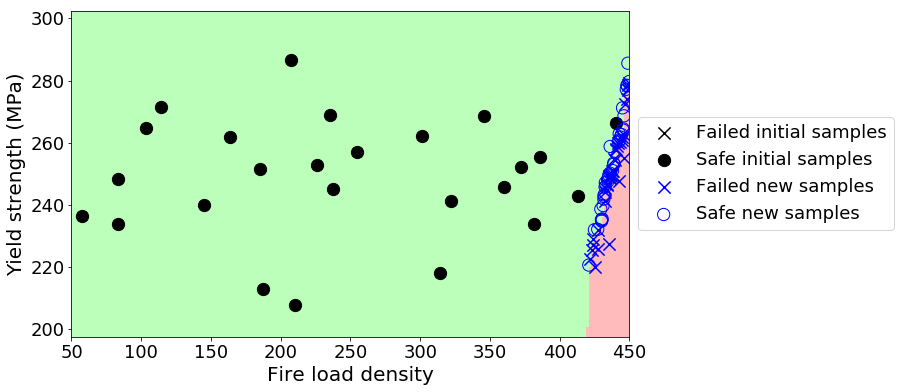

In [10]:
f1, ax1 = plt.subplots(figsize=(10, 6))
cmap_light = ListedColormap(['#FFBBBB', '#BBFFBB'])
cmap_bold = ListedColormap(['#CC0000', '#00AA00'])
plt.pcolormesh(x1g, x2g/1e6, y2 > 0, cmap=cmap_light)

plt.scatter(S_initial0[Y_initial <= 0], S_initial1[Y_initial<=0], color='Black', marker="x", label='Failed initial samples', s=ss)
plt.scatter(S_initial0[Y_initial>0], S_initial1[Y_initial>0], color='Black', marker="o", label='Safe initial samples', s=ss)
plt.scatter(S_final0[Y_final<=0], S_final1[Y_final<=0], color='Blue', marker="x", label='Failed new samples', s=ss, )
plt.scatter(S_final0[Y_final>0], S_final1[Y_final>0], color='Blue', marker="o", label='Safe new samples', s=ss, facecolors='none')

plt.xlabel('Fire load density', fontsize=fs+2)
plt.ylabel('Yield strength (MPa)', fontsize=fs+2)
plt.xlim(min(x1), max(x1))
plt.ylim(min(x2)/1e6, max(x2)/1e6)
plt.tick_params(axis='both', labelsize=fs, which='major')
plt.legend(bbox_to_anchor=(1, 0.5), loc='center left', ncol=1, fontsize=fs)
plt.show()

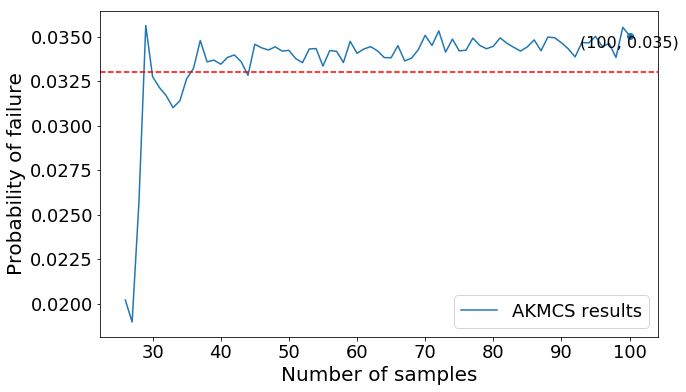

In [11]:
# MCS result (10000 samples): probability of failure = 0.033
PF = 0.033
pf = akmcs.pf
plt.figure(figsize=(10, 6))
ax = plt.axes()
plt.plot(np.arange(nd+1, len(qois)+1), pf, label='AKMCS results')
plt.xlabel('Number of samples', fontsize=fs+2)
plt.ylabel('Probability of failure', fontsize=fs+2)
ax.tick_params(axis='both', labelsize=fs, which='major')
xyc = (akmcs.samples.shape[0], pf[-1])
ax.annotate('(%s, %0.3f)' % xyc, xy=xyc, fontsize=fs-2, horizontalalignment='center', verticalalignment='top')
plt.scatter(akmcs.samples.shape[0], pf[-1], marker="o")
ax.axhline(y=PF, color='r', linestyle='--')
plt.rc('legend', fontsize=fs)
plt.legend()
plt.show()

In [12]:
print('Example: Done!')
print('Time elapsed: %.2f minutes' % float((time.time() - t) / 60.0))

Example: Done!
Time elapsed: 95.36 minutes
